In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

Separating everything into months and quarters for easier aggregation.

In [2]:
gdp = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/variables_svar_model/gdp.csv')
gov_bonds_ytm = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/variables_svar_model/gov_bonds_ytm.csv')
cpi = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/variables_svar_model/consumer_price_index_percent_of_previous_month.csv')
neer = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/variables_svar_model/Effective_exchange_rates_monthly.csv')
vix = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/variables_svar_model/VIX_History.csv')
credit_spread = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/variables_svar_model/g_spread.csv').rename(columns={"????": "date", "????????": "g_spread"})
mortgage_rate = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/variables_svar_model/mortgage_rate.csv')
industrial_production = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/variables_svar_model/industrial_production_index.csv')
ofz2_shock = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/variables_svar_model/ofz2_shock.csv')
shocks = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/news_component_sbert.csv')

In [3]:
previews = pd.read_excel('https://github.com/tssorokina/information_component_of_monetary_shocks/blob/main/cbr_previews.xlsx?raw=true')

In [4]:
svar_variables = pd.DataFrame()

### GDP

In [5]:
new_gdp = pd.DataFrame(columns=['year', 'quarter', 'date_start_onemonth_before', 'exact_quarter_start'])
for i, row in gdp.iterrows():
    new_gdp = new_gdp.append({'year': row['Unnamed: 0'],
                    'quarter': 1,
                    'gdp': row['1_quarter'],
                    'date_start_onemonth_before': datetime(row['Unnamed: 0']-1, 12,1),
                    'exact_quarter_start': datetime(row['Unnamed: 0'], 1,1)
                    }, ignore_index=True).append({'year': row['Unnamed: 0'],
                    'quarter': 2,
                    'gdp': row['2_quarter'],
                    'date_start_onemonth_before': datetime(row['Unnamed: 0'], 3,1),
                    'exact_quarter_start': datetime(row['Unnamed: 0'], 4,1)
                    }, ignore_index=True).append({'year': row['Unnamed: 0'],
                    'quarter': 3,
                    'gdp': row['3_quarter'],
                    'date_start_onemonth_before': datetime(row['Unnamed: 0'], 6,1),
                    'exact_quarter_start': datetime(row['Unnamed: 0'], 7,1)
                    },ignore_index=True).append({'year': row['Unnamed: 0'],
                    'quarter': 4,
                    'gdp': row['4_quarter'],
                    'date_start_onemonth_before': datetime(row['Unnamed: 0'], 9,1),
                    'exact_quarter_start': datetime(row['Unnamed: 0'], 10,1)
                    }, ignore_index=True)
new_gdp

,year,quarter,date_start_onemonth_before,exact_quarter_start,gdp
0,1999,1,1998-12-01,1999-01-01,901.0
1,1999,2,1999-03-01,1999-04-01,1102.0
2,1999,3,1999-06-01,1999-07-01,1373.0
3,1999,4,1999-09-01,1999-10-01,1447.0
4,2000,1,1999-12-01,2000-01-01,1527.0
...,...,...,...,...,...
87,2020,4,2020-09-01,2020-10-01,31088.0
88,2021,1,2020-12-01,2021-01-01,27091.0
89,2021,2,2021-03-01,2021-04-01,30915.0
90,2021,3,2021-06-01,2021-07-01,34225.0


### CPI

We need to consider a ratio to a certain base year because if we aggregate by quarters, the count will be more precise.

In [6]:
# seeing as the data for cpi is presented 
new_cpi = pd.DataFrame(columns=['year', 'quarter', 'month', 'cpi_to_last_month', 'cpi_to_2010'])
new_cpi = new_cpi.append({'year':2010,
                                  # 'date': 2010,
                                  'month': 0,
                                  'cpi_to_last_month': 0,
                                  'cpi_to_2010': 100
                                  }, ignore_index=True)
for i, row in cpi.iloc[1:].reset_index(drop=True).iterrows():
    for i in range(1, 13):
        new_cpi = new_cpi.append({'year':int(row['year']),
                                  'quarter': 1 if i in [1,2,3] else 2 if i in [4,5,6] else 3 if i in [7,8,9] else 4,
                                  'month': i,
                                  # 'date': datetime(int(row['year']), i, 1),
                                  'inflation_to_last_month': row[f'{i}']-100,
                                  'cpi_to_2010': new_cpi.iloc[-1,4]*row[f'{i}']/100
                                  }, ignore_index=True)
new_cpi = new_cpi.iloc[1:]
new_cpi.year = new_cpi.year.astype(int)
new_cpi.quarter = new_cpi.quarter.astype(int)
new_cpi.month = new_cpi.month.astype(int)
new_cpi

,year,quarter,month,cpi_to_last_month,cpi_to_2010,inflation_to_last_month
1,2011,1,1,NaN,102.400000,2.4
2,2011,1,2,NaN,103.219200,0.8
3,2011,1,3,NaN,103.838515,0.6
4,2011,2,4,NaN,104.253869,0.4
5,2011,2,5,NaN,104.775139,0.5
...,...,...,...,...,...,...
128,2021,3,8,NaN,193.595510,0.2
129,2021,3,9,NaN,194.757083,0.6
130,2021,4,10,NaN,196.899411,1.1
131,2021,4,11,NaN,198.868405,1.0


In [7]:
# svar_variables['year'] = new_cpi[new_cpi['year'] > 2014].reset_index(drop=True)['year']
# svar_variables['quarter'] = new_cpi[new_cpi['year'] > 2014].reset_index(drop=True)['quarter']
# svar_variables['month'] = new_cpi[new_cpi['year'] > 2014].reset_index(drop=True)['month']
# svar_variables['cpi'] = new_cpi[new_cpi['year'] > 2014].reset_index(drop=True)['cpi_to_2010']

svar_variables['year'] = new_cpi.iloc[33:].reset_index(drop=True)['year']
svar_variables['quarter'] = new_cpi.iloc[33:].reset_index(drop=True)['quarter']
svar_variables['month'] = new_cpi.iloc[33:].reset_index(drop=True)['month']
svar_variables['cpi_to_2010'] = new_cpi.iloc[33:].reset_index(drop=True)['cpi_to_2010']
svar_variables['monthly_inflation'] = new_cpi.iloc[33:].reset_index(drop=True)['inflation_to_last_month']

svar_variables

,year,quarter,month,cpi_to_2010,monthly_inflation
0,2013,4,10,119.152013,0.6
1,2013,4,11,119.866925,0.6
2,2013,4,12,120.466259,0.5
3,2014,1,1,121.189057,0.6
4,2014,1,2,122.037380,0.7
...,...,...,...,...,...
94,2021,3,8,193.595510,0.2
95,2021,3,9,194.757083,0.6
96,2021,4,10,196.899411,1.1
97,2021,4,11,198.868405,1.0


### IP

In [8]:
industrial_production

,year,1_quarter,2_quarter,3_quarter,4_quarter,1,2,3,4,5,6,7,8,9,10,11,12
0,2015,89.0,100.8,102.6,108.5,82.6,97.2,110.9,95.3,98.9,101.6,101.3,100.5,101.0,105.2,99.5,107.9
1,2016,89.7,100.7,103.9,111.0,82.7,100.1,109.7,94.3,99.5,102.3,100.5,102.3,101.3,105.8,101.6,106.6
2,2017,89.6,102.0,103.1,107.4,84.9,95.4,111.8,95.0,101.3,101.5,99.6,102.9,100.2,104.0,100.4,105.7
3,2018,91.0,102.1,103.0,110.1,86.9,95.8,111.4,95.4,101.6,100.2,101.0,102.1,99.8,107.0,99.6,107.8
4,2019,89.1,102.1,104.3,108.4,83.8,97.2,109.9,97.7,97.6,102.3,102.1,101.7,100.9,106.3,96.8,109.0
5,2020,89.4,92.8,106.4,112.4,83.0,100.5,107.5,90.8,94.1,103.6,103.2,103.5,101.3,104.4,101.2,114.2
6,2021,88.8,103.1,103.0,113.5,78.2,99.1,113.4,95.8,98.2,102.0,100.2,101.3,103.6,105.1,101.3,112.5


In [9]:
new_ip = pd.DataFrame(columns=['year', 'quarter', 'month', 'ip', 'ip_to_december_2014'])
new_ip = new_ip.append({'year':0,
                        'quarter':0,
                                  'month': 0,
                                  'ip': 0,
                                  'ip_to_december_2014': 100
                                  }, ignore_index=True)

for i, row in industrial_production.iterrows():
    for i in range(1, 13):
        new_ip = new_ip.append({'year':int(row['year']),
                                  'quarter': 1 if i in [1,2,3] else 2 if i in [4,5,6] else 3 if i in [7,8,9] else 4,
                                  'month': i,
                                  'ip': row[f'{i}'],
                                  'ip_to_december_2014': new_ip.iloc[-1,4] * row[f'{i}'] / 100
                                  }, ignore_index=True)
new_ip = new_ip.iloc[1:]
new_ip.year = new_ip.year.astype(int)
new_ip.quarter = new_ip.quarter.astype(int)
new_ip.month = new_ip.month.astype(int)
new_ip

,year,quarter,month,ip,ip_to_december_2014
1,2015,1,1,82.6,82.6
2,2015,1,2,97.2,80.2872
3,2015,1,3,110.9,89.038505
4,2015,2,4,95.3,84.853695
5,2015,2,5,98.9,83.920304
...,...,...,...,...,...
80,2021,3,8,101.3,100.086781
81,2021,3,9,103.6,103.689905
82,2021,4,10,105.1,108.97809
83,2021,4,11,101.3,110.394805


In [10]:
# svar_variables['ip'] = new_ip['ip_to_december_2014'].reset_index(drop=True)
svar_variables['ip_to_2014'] = (len(svar_variables)-len(new_ip))*[np.nan] + new_ip['ip_to_december_2014'].reset_index(drop=True).tolist()
svar_variables['ip'] = (len(svar_variables)-len(new_ip))*[np.nan] + new_ip['ip'].reset_index(drop=True).tolist()
svar_variables

,year,quarter,month,cpi_to_2010,monthly_inflation,ip_to_2014,ip
0,2013,4,10,119.152013,0.6,NaN,NaN
1,2013,4,11,119.866925,0.6,NaN,NaN
2,2013,4,12,120.466259,0.5,NaN,NaN
3,2014,1,1,121.189057,0.6,NaN,NaN
4,2014,1,2,122.037380,0.7,NaN,NaN
...,...,...,...,...,...,...,...
94,2021,3,8,193.595510,0.2,100.086781,101.3
95,2021,3,9,194.757083,0.6,103.689905,103.6
96,2021,4,10,196.899411,1.1,108.978090,105.1
97,2021,4,11,198.868405,1.0,110.394805,101.3


### Credit Spread

We simply take monthly average because I could not find the data on volume.

In [11]:
# credit_spread = credit_spread.iloc[::-1].reset_index(drop=True)

credit_spread['year'] = [int(date[-4:]) for date in credit_spread['date']]
credit_spread['month'] = [int(date[:date.find('/')]) for date in credit_spread['date']]
credit_spread['day'] = [int(date[date.find('/')+1:date.rfind('/')]) for date in credit_spread['date']]

# credit_spread = credit_spread[credit_spread['year'] > 2014]

In [12]:
mylist = []
for year in range(2014, 2022):
    mylist += credit_spread[credit_spread['year'] == year].groupby(by='month').mean()['g_spread'].tolist()

In [13]:
svar_variables['credit_spread'] = (len(svar_variables)-len(mylist))*[np.nan] + mylist
svar_variables

,year,quarter,month,cpi_to_2010,monthly_inflation,ip_to_2014,ip,credit_spread
0,2013,4,10,119.152013,0.6,NaN,NaN,NaN
1,2013,4,11,119.866925,0.6,NaN,NaN,NaN
2,2013,4,12,120.466259,0.5,NaN,NaN,NaN
3,2014,1,1,121.189057,0.6,NaN,NaN,139.270000
4,2014,1,2,122.037380,0.7,NaN,NaN,110.882500
...,...,...,...,...,...,...,...,...
94,2021,3,8,193.595510,0.2,100.086781,101.3,72.095909
95,2021,3,9,194.757083,0.6,103.689905,103.6,72.679091
96,2021,4,10,196.899411,1.1,108.978090,105.1,73.161905
97,2021,4,11,198.868405,1.0,110.394805,101.3,64.631429


### VIX

Average VIX over the month. Again, no data on volume.

In [14]:
vix['year'] = [int(date[-4:]) for date in vix['DATE']]
vix['month'] = [int(date[:date.find('/')]) for date in vix['DATE']]
vix['day'] = [int(date[date.find('/')+1:date.rfind('/')]) for date in vix['DATE']]

vix = vix[vix['year'] > 2012].iloc[188:].reset_index(drop=True)

In [15]:
mylist = []
for year in range(2013, 2022):
    mylist += vix[vix['year'] == year].groupby(by='month').mean()['CLOSE'].tolist()

In [16]:
svar_variables

,year,quarter,month,cpi_to_2010,monthly_inflation,ip_to_2014,ip,credit_spread
0,2013,4,10,119.152013,0.6,NaN,NaN,NaN
1,2013,4,11,119.866925,0.6,NaN,NaN,NaN
2,2013,4,12,120.466259,0.5,NaN,NaN,NaN
3,2014,1,1,121.189057,0.6,NaN,NaN,139.270000
4,2014,1,2,122.037380,0.7,NaN,NaN,110.882500
...,...,...,...,...,...,...,...,...
94,2021,3,8,193.595510,0.2,100.086781,101.3,72.095909
95,2021,3,9,194.757083,0.6,103.689905,103.6,72.679091
96,2021,4,10,196.899411,1.1,108.978090,105.1,73.161905
97,2021,4,11,198.868405,1.0,110.394805,101.3,64.631429


In [17]:
svar_variables['vix'] = mylist
svar_variables

,year,quarter,month,cpi_to_2010,monthly_inflation,ip_to_2014,ip,credit_spread,vix
0,2013,4,10,119.152013,0.6,NaN,NaN,NaN,15.407826
1,2013,4,11,119.866925,0.6,NaN,NaN,NaN,12.924000
2,2013,4,12,120.466259,0.5,NaN,NaN,NaN,14.192381
3,2014,1,1,121.189057,0.6,NaN,NaN,139.270000,14.240952
4,2014,1,2,122.037380,0.7,NaN,NaN,110.882500,15.470000
...,...,...,...,...,...,...,...,...,...
94,2021,3,8,193.595510,0.2,100.086781,101.3,72.095909,17.472727
95,2021,3,9,194.757083,0.6,103.689905,103.6,72.679091,19.824762
96,2021,4,10,196.899411,1.1,108.978090,105.1,73.161905,17.871429
97,2021,4,11,198.868405,1.0,110.394805,101.3,64.631429,18.500476


### NEER

In [18]:
neer

,date,EER
0,9/1/2013,92.88
1,10/1/2013,92.92
2,11/1/2013,91.93
3,12/1/2013,91.05
4,1/1/2014,89.10
...,...,...
99,12/1/2021,49.19
100,1/1/2022,47.36
101,2/1/2022,46.15
102,3/1/2022,35.54


In [19]:
neer['year'] = [int(date[-4:]) for date in neer['date']]
neer['month'] = [int(date[:date.find('/')]) for date in neer['date']]
neer['day'] = [int(date[date.find('/')+1:date.rfind('/')]) for date in neer['date']]

# neer = neer[neer['year'] > 2014]
neer = neer.iloc[1:]

mylist = []
for year in range(2013, 2022):
    mylist += neer[neer['year'] == year].groupby(by='month').mean()['EER'].tolist()

In [20]:
svar_variables['neer'] = mylist
svar_variables

,year,quarter,month,cpi_to_2010,monthly_inflation,ip_to_2014,ip,credit_spread,vix,neer
0,2013,4,10,119.152013,0.6,NaN,NaN,NaN,15.407826,92.92
1,2013,4,11,119.866925,0.6,NaN,NaN,NaN,12.924000,91.93
2,2013,4,12,120.466259,0.5,NaN,NaN,NaN,14.192381,91.05
3,2014,1,1,121.189057,0.6,NaN,NaN,139.270000,14.240952,89.10
4,2014,1,2,122.037380,0.7,NaN,NaN,110.882500,15.470000,85.09
...,...,...,...,...,...,...,...,...,...,...
94,2021,3,8,193.595510,0.2,100.086781,101.3,72.095909,17.472727,47.75
95,2021,3,9,194.757083,0.6,103.689905,103.6,72.679091,19.824762,48.21
96,2021,4,10,196.899411,1.1,108.978090,105.1,73.161905,17.871429,49.75
97,2021,4,11,198.868405,1.0,110.394805,101.3,64.631429,18.500476,49.32


### Mortgage Spread

In [21]:
mortgage_rate = mortgage_rate.iloc[:,:4]
mortgage_rate['year'] = [int(date[-4:]) for date in mortgage_rate['Unnamed: 0']]
mortgage_rate['month'] = [int(date[:date.find('/')]) for date in mortgage_rate['Unnamed: 0']]
mortgage_rate['day'] = [int(date[date.find('/')+1:date.rfind('/')]) for date in mortgage_rate['Unnamed: 0']]

# mortgage_rate = mortgage_rate[mortgage_rate['year'] > 2014].iloc[::-1].reset_index(drop=True)
mortgage_rate = mortgage_rate.iloc[::-1].reset_index(drop=True)
mortgage_rate

,Unnamed: 0,key_rate,MIACR,Mortgage_rate,year,month,day
0,1/1/2014,5.50,6.06,12.44,2014,1,1
1,2/1/2014,5.50,5.99,12.28,2014,2,1
2,3/1/2014,5.50,7.85,12.29,2014,3,1
3,4/1/2014,7.00,7.87,12.16,2014,4,1
4,5/1/2014,7.50,8.21,12.20,2014,5,1
...,...,...,...,...,...,...,...
80,9/1/2020,4.25,4.16,7.26,2020,9,1
81,10/1/2020,4.25,4.17,7.32,2020,10,1
82,11/1/2020,4.25,4.17,7.31,2020,11,1
83,12/1/2020,4.25,4.06,7.38,2020,12,1


In [22]:
# mylist_mortgage = []
# for year in range(2015, 2022):
#     mylist_mortgage += mortgage_rate[mortgage_rate['year'] == year].groupby(by='month').mean()['Mortgage_rate'].tolist()
# mylist_mortgage = [round(rate,2) for rate in mylist_mortgage]

In [23]:
gov_bonds_ytm['year'] = [int(date[-4:]) for date in gov_bonds_ytm['date']]
gov_bonds_ytm['day'] = [int(date[:date.find('.')]) for date in gov_bonds_ytm['date']]
gov_bonds_ytm['month'] = [int(date[date.find('.')+1:date.rfind('.')]) for date in gov_bonds_ytm['date']]

gov_bonds_ytm = gov_bonds_ytm[gov_bonds_ytm['year'] > 2013].iloc[::-1].reset_index(drop=True)
gov_bonds_ytm = gov_bonds_ytm.iloc[::-1].reset_index(drop=True).iloc[21:]

mylist = []
for year in range(2014, 2022):
    mylist += gov_bonds_ytm[gov_bonds_ytm['year'] == year].groupby(by='month').mean()['5'].tolist()
mylist = [round(rate,2) for rate in mylist]

In [24]:
mylist

[7.45,
 7.83,
 8.91,
 8.73,
 8.77,
 8.33,
 8.74,
 9.57,
 9.66,
 9.93,
 10.45,
 13.81,
 15.34,
 13.41,
 13.08,
 11.41,
 10.71,
 11.09,
 10.97,
 11.46,
 11.56,
 10.41,
 9.94,
 10.01,
 10.43,
 10.2,
 9.28,
 9.24,
 9.07,
 8.89,
 8.69,
 8.6,
 8.31,
 8.54,
 8.77,
 8.47,
 8.01,
 8.12,
 8.08,
 7.93,
 7.74,
 7.81,
 7.94,
 7.82,
 7.56,
 7.46,
 7.51,
 7.27,
 7.03,
 6.8,
 6.67,
 6.96,
 7.03,
 7.34,
 7.47,
 8.25,
 8.59,
 8.5,
 8.61,
 8.55,
 8.23,
 8.09,
 8.08,
 8.01,
 7.85,
 7.47,
 7.21,
 7.1,
 6.8,
 6.46,
 6.21,
 6.16,
 5.92,
 5.81,
 6.94,
 6.19,
 5.2,
 5.12,
 5.17,
 5.32,
 5.53,
 5.42,
 5.33,
 5.39,
 5.63,
 6.01,
 6.58,
 6.8,
 6.7,
 6.93,
 6.99,
 6.86,
 7.04,
 7.65,
 8.5,
 8.59]

In [25]:
# svar_variables['mortgage_spread'] = [round(mylist_mortgage[i]-mylist[i],2) for i in range(len(mylist_mortgage))] + [np.nan] * (len(svar_variables)-len(mylist_mortgage))
svar_variables['mortgage_spread'] = 3*[np.nan]+[round(mortgage_rate['Mortgage_rate'][i]-mylist[i],2) for i in range(len(mortgage_rate['Mortgage_rate']))] + [np.nan] * (len(svar_variables)-len(mortgage_rate['Mortgage_rate'])-3)
svar_variables

,year,quarter,month,cpi_to_2010,monthly_inflation,ip_to_2014,ip,credit_spread,vix,neer,mortgage_spread
0,2013,4,10,119.152013,0.6,NaN,NaN,NaN,15.407826,92.92,NaN
1,2013,4,11,119.866925,0.6,NaN,NaN,NaN,12.924000,91.93,NaN
2,2013,4,12,120.466259,0.5,NaN,NaN,NaN,14.192381,91.05,NaN
3,2014,1,1,121.189057,0.6,NaN,NaN,139.270000,14.240952,89.10,4.99
4,2014,1,2,122.037380,0.7,NaN,NaN,110.882500,15.470000,85.09,4.45
...,...,...,...,...,...,...,...,...,...,...,...
94,2021,3,8,193.595510,0.2,100.086781,101.3,72.095909,17.472727,47.75,NaN
95,2021,3,9,194.757083,0.6,103.689905,103.6,72.679091,19.824762,48.21,NaN
96,2021,4,10,196.899411,1.1,108.978090,105.1,73.161905,17.871429,49.75,NaN
97,2021,4,11,198.868405,1.0,110.394805,101.3,64.631429,18.500476,49.32,NaN


### Pure monetary shock

In [51]:
shocks['date'] = shocks['date'].iloc[::-1].reset_index(drop=True)
for var in list(shocks)[3:]:
  svar_variables[var] = [0] * len(svar_variables)

svar_variables['key_rate'] = [-10] * len(svar_variables)

for i, row in svar_variables.iterrows():
    mask = shocks[[bool(([(int(date[:4]) == row.year)*1 for date in shocks['date']])[i] * ([(int(date[5:7]) == row.month) * 1 for date in shocks['date']])[i]) for i in range(len(shocks['date']))]]
    if len(mask) == 2:
      row.key_rate = mask.iloc[1]['key_rate_ofz2']
      for var in list(shocks)[3:]:
        row[var] = mask.iloc[1][var]
    elif len(mask) == 1:
      row.key_rate = mask.iloc[0]['key_rate_ofz2']
      for var in list(shocks)[3:]:
        row[var] = mask.iloc[0][var]
    
    svar_variables.drop(i)
    svar_variables.iloc[i] =  row


for i in svar_variables[svar_variables['key_rate'] == -10].index.tolist():
    svar_variables.iloc[i,-1] = svar_variables.iloc[i-1,-1]
svar_variables

,year,quarter,month,cpi_to_2010,monthly_inflation,ip_to_2014,ip,credit_spread,vix,neer,...,pure_monetary_shock_one_component,capured_monetary_shock_one_component,news_component_one_component,pure_monetary_shock_uip_based_usd,capured_monetary_shock_uip_based_usd,news_component_uip_based_usd,pure_monetary_shock_uip_based_eur,capured_monetary_shock_uip_based_eur,news_component_uip_based_eur,key_rate
0,2013,4,10,119.152013,0.6,NaN,NaN,NaN,15.407826,92.92,...,-0.215951,-0.419935,-0.203984,0.163928,0.124181,-0.039747,-0.007777,-0.000725,0.007052,5.50
1,2013,4,11,119.866925,0.6,NaN,NaN,NaN,12.924000,91.93,...,-0.030692,0.094678,0.125370,0.067639,0.032107,-0.035532,-0.073522,-0.058373,0.015148,5.50
2,2013,4,12,120.466259,0.5,NaN,NaN,NaN,14.192381,91.05,...,0.160726,-0.105000,-0.265726,-0.129086,-0.156453,-0.027367,-0.064854,-0.028184,0.036669,5.50
3,2014,1,1,121.189057,0.6,NaN,NaN,139.270000,14.240952,89.10,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.50
4,2014,1,2,122.037380,0.7,NaN,NaN,110.882500,15.470000,85.09,...,0.599106,0.082691,-0.516415,0.010282,-0.042782,-0.053064,-0.007163,-0.020070,-0.012908,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2021,3,8,193.595510,0.2,100.086781,101.3,72.095909,17.472727,47.75,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.50
95,2021,3,9,194.757083,0.6,103.689905,103.6,72.679091,19.824762,48.21,...,-0.170184,-0.447918,-0.277734,0.000003,-0.045840,-0.045843,-0.011488,0.002443,0.013931,6.75
96,2021,4,10,196.899411,1.1,108.978090,105.1,73.161905,17.871429,49.75,...,-0.211429,-0.060062,0.151367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.50
97,2021,4,11,198.868405,1.0,110.394805,101.3,64.631429,18.500476,49.32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.50


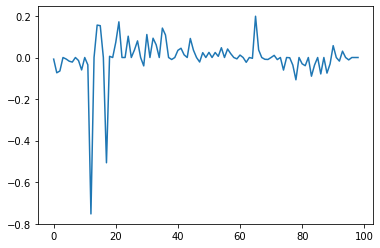

In [54]:
plt.plot(svar_variables['pure_monetary_shock_uip_based_eur'])

In [55]:
svar_variables.to_csv('svar_dataset.csv')

## Analysis

In [29]:
import matplotlib.pyplot as plt

In [41]:
shocks[::-1].reset_index(drop=True).drop('Unnamed: 0', axis=1)

,date,key_rate_ofz2,pure_monetary_shock_ofz2,capured_monetary_shock_ofz2,news_component_ofz2,pure_monetary_shock_ofz4,capured_monetary_shock_ofz4,news_component_ofz4,pure_monetary_shock_ofz6,capured_monetary_shock_ofz6,...,news_component_ofz15,pure_monetary_shock_one_component,capured_monetary_shock_one_component,news_component_one_component,pure_monetary_shock_uip_based_usd,capured_monetary_shock_uip_based_usd,news_component_uip_based_usd,pure_monetary_shock_uip_based_eur,capured_monetary_shock_uip_based_eur,news_component_uip_based_eur
0,2013-10-14 11:05:00,8.50,0.001504,0.002137,0.000633,-0.001785,0.000000,0.001785,-0.000663,0.000000,...,-0.003060,-0.159523,-0.465714,-0.306191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-11-08 10:27:00,7.50,0.000297,-0.000715,-0.001012,-0.002189,-0.004141,-0.001952,0.002498,-0.001030,...,-0.001690,-0.211429,-0.060062,0.151367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-12-13 13:27:00,6.75,0.001025,0.000903,-0.000122,0.000136,0.000000,-0.000136,0.001086,-0.000398,...,-0.000600,-0.170184,-0.447918,-0.277734,0.000003,-0.045840,-0.045843,-0.011488,0.002443,0.013931
3,2014-02-14 13:33:00,6.50,0.003605,0.001902,-0.001703,0.006711,0.000000,-0.006711,0.012647,0.003886,...,-0.000202,-1.487212,-1.127918,0.359294,0.198613,0.132624,-0.065989,0.030506,0.003564,-0.026942
4,2014-03-03 10:26:00,5.50,-0.000932,0.000000,0.000932,-0.003248,0.000000,0.003248,-0.003827,0.000000,...,0.000928,0.519718,-0.098346,-0.618064,-0.011926,-0.055808,-0.043882,-0.017359,-0.002495,0.014864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2021-06-11 13:30:00,7.00,-0.004737,-0.003752,0.000985,-0.006147,-0.002921,0.003226,-0.003766,0.000000,...,-0.000920,1.703287,1.077663,-0.625624,0.046949,-0.008026,-0.054975,0.025752,0.004856,-0.020897
64,2021-07-23 13:30:00,5.50,-0.001194,-0.000404,0.000791,-0.005017,-0.003468,0.001548,-0.001802,0.000000,...,0.001464,0.599106,0.082691,-0.516415,0.010282,-0.042782,-0.053064,-0.007163,-0.020070,-0.012908
65,2021-09-10 13:30:00,5.50,-0.000929,-0.000602,0.000327,-0.001638,-0.000490,0.001147,-0.002686,-0.000662,...,0.001364,0.160726,-0.105000,-0.265726,-0.129086,-0.156453,-0.027367,-0.064854,-0.028184,0.036669
66,2021-10-22 13:30:00,5.50,0.001007,0.000100,-0.000907,-0.008267,-0.011577,-0.003310,0.004104,0.000000,...,0.001397,-0.030692,0.094678,0.125370,0.067639,0.032107,-0.035532,-0.073522,-0.058373,0.015148


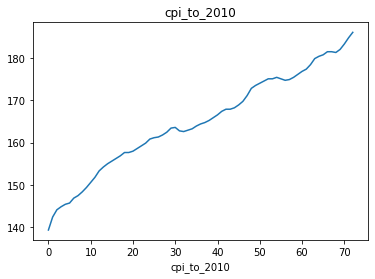

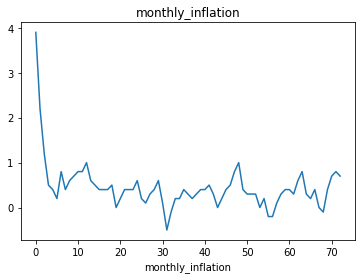

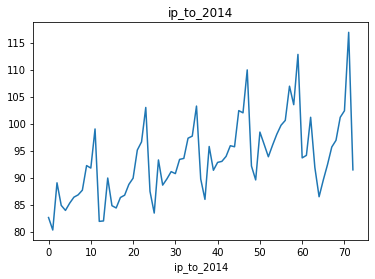

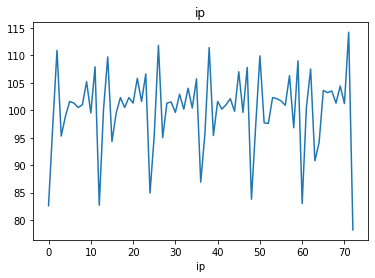

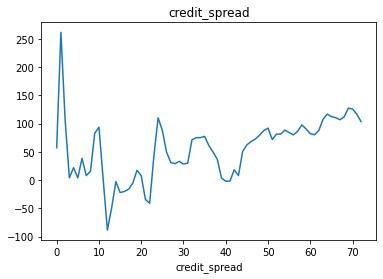

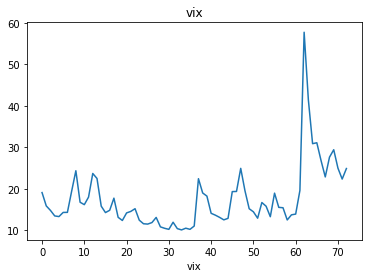

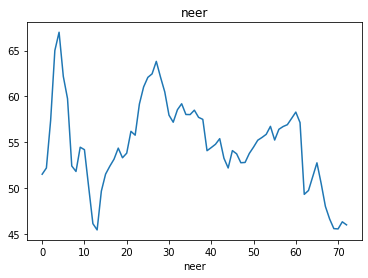

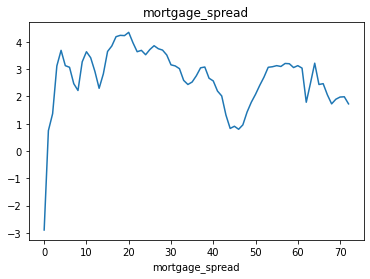

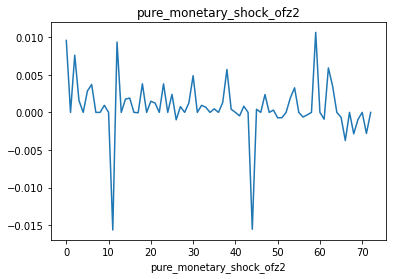

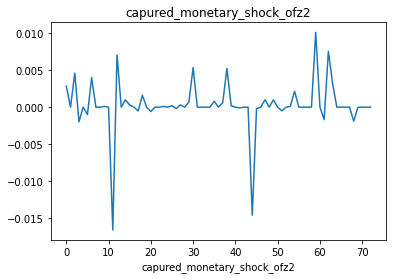

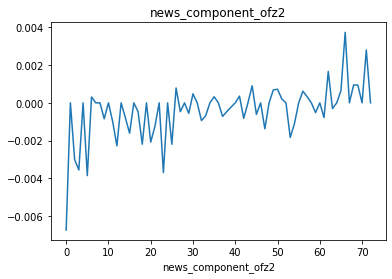

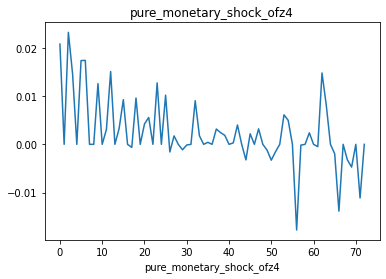

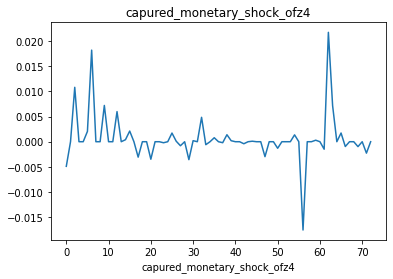

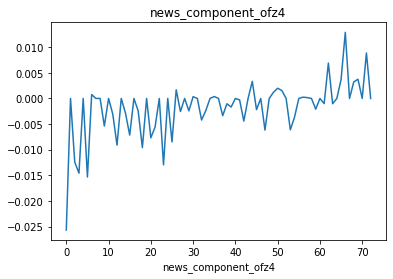

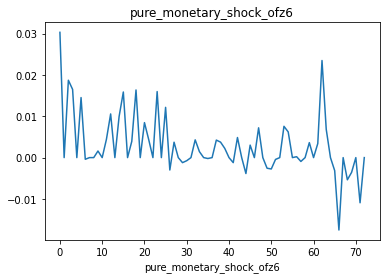

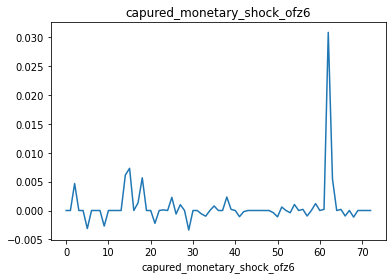

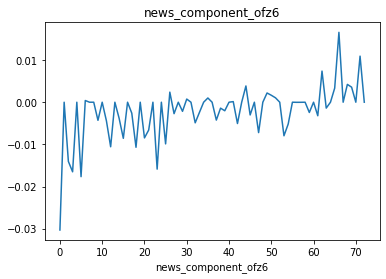

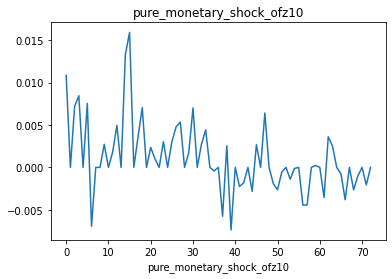

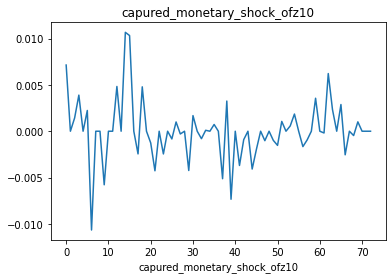

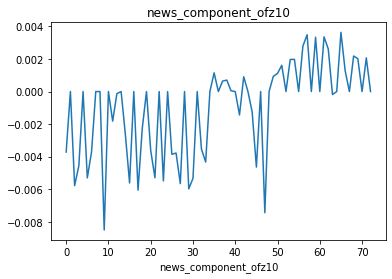

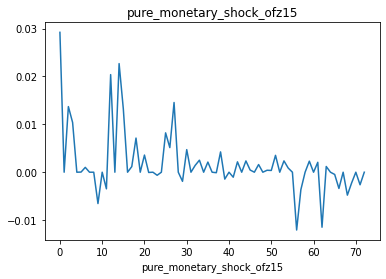

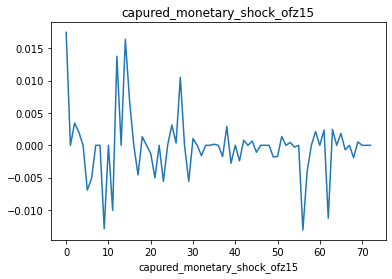

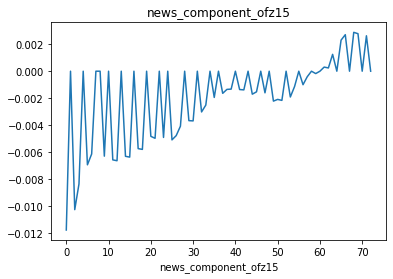

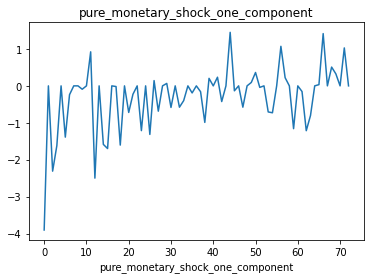

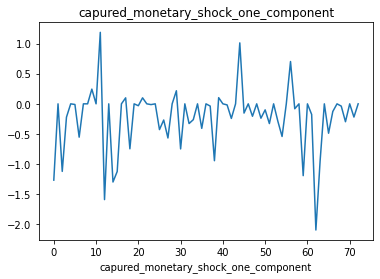

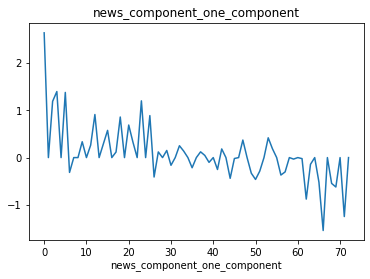

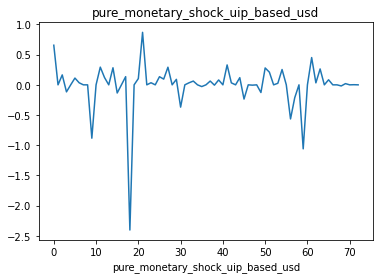

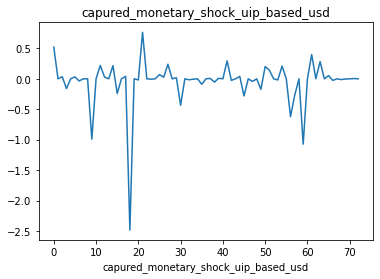

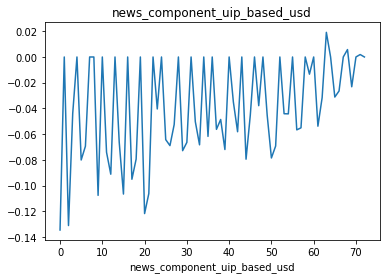

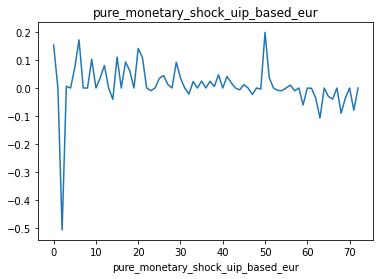

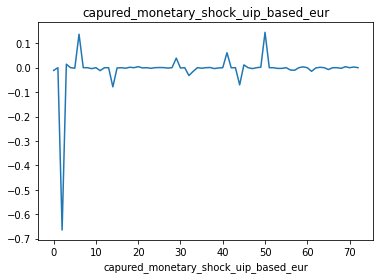

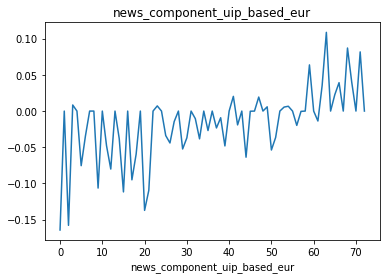

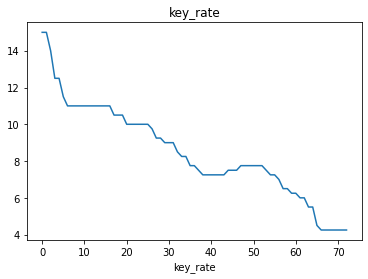

In [48]:
for i in range(len(list(svar_variables.dropna().iloc[:,3:].reset_index(drop=True)))) :
    col_name = svar_variables.dropna().iloc[:,3:].reset_index(drop=True).columns[i]  # get the column name to identify the graph
    x=svar_variables.dropna().iloc[:,3:].reset_index(drop=True)[col_name]
    plt.xlabel(col_name)         # The column name will be the x-label ( just to identify )
    # k=plt.hist(x)
    plt.plot(x)
    plt.title(col_name)
    plt.show()